In [1]:
"""
This script is used to analyze data and produce Suplementary Figures of the manuscript
'Plasmid-mediated phenotypic noise leads to transient antibiotic resistance in bacteria'.

MIT License

Copyright (c) 2023 JCRHB/RPM

""";


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.colors as colors


In [4]:


rootDir = "/content/drive/MyDrive/SYNC_Projects/"

rootDir = os.path.join(rootDir, "pBGT/GIT/")
workingDir = os.path.join(rootDir, "code/Supplementary/")
data_path = os.path.join(rootDir, "data/uJ_data/")
fig_path = os.path.join(rootDir, "figures/SuppFigures/")


dark_orange='#FF985A'
light_orange='#FFDC97'
dark_blue='#779ECC'
light_blue='#9FC0DE'

frame2min=10
px2um=12.8

This code loads and processes two input data files: "processed_lineages.csv" and "cells_summary.csv". It creates a new dataframe called "status_time_df" by merging data from the two input dataframes based on experiment ID, cell ID, and time. It also updates the column names and categories of the input dataframes for consistency and clarity.

In [5]:

# Load the "processed_lineages.csv" file as a Pandas DataFrame called lineages_raw_df
lineages_file = data_path + "processed_lineages.csv"
lineages_raw_df = pd.read_csv(lineages_file)

# Update the column names in lineages_raw_df
lineages_processed_df = lineages_raw_df.copy()
lineages_processed_df["filamented_id"] = pd.Categorical(lineages_processed_df["filamented_id"], categories=[False, True], ordered=True).rename_categories(["Not filamented", "Filamented"])
lineages_processed_df["filamented_at_time"] = pd.Categorical(lineages_processed_df["filamented_at_time"], categories=[False, True], ordered=True).rename_categories(["Not filamented", "Filamented"])
lineages_processed_df["survived"] = pd.Categorical(lineages_processed_df["survived"], categories=[False, True], ordered=True).rename_categories(["Not survived", "Survived"])
lineages_processed_df["cell_status"] = (lineages_processed_df["filamented_id"].astype(str) + " - " + lineages_processed_df["survived"].astype(str)).astype("category")
# Processing and cleaning up the cells_summary.csv file
cells_file = data_path + "cells_summary.csv"
cells_raw_df = pd.read_csv(cells_file).drop("over_ds_red_id", axis=1).rename(columns={"divided_id": "divided"})

cells_df = cells_raw_df.copy()
cells_df["filamented_id"] = pd.Categorical(cells_df["filamented_id"], categories=[False, True], ordered=True).rename_categories(["Not filamented", "Filamented"])
cells_df["survived"] = pd.Categorical(cells_df["survived"], categories=[False, True], ordered=True).rename_categories(["Not survived", "Survived"])
cells_df["cell_status"] = (cells_df["filamented_id"].astype(str) + " - " + cells_df["survived"].astype(str)).astype("category")
cells_df = cells_df.loc[:, cells_df.dtypes == "object"].join(cells_df.select_dtypes(include=["category", "bool"]))

# Creating a new dataframe 'status_time_df' by merging with a new dataframe
status_time_df = (lineages_processed_df
                  .loc[:, ['experiment_id', 'id', 'time']]
                  .groupby(['experiment_id', 'id'], group_keys=False)
                  .apply(lambda x: x.set_index('time').reindex(range(x['time'].nunique()), fill_value=np.nan))
                  .reset_index()
                  .merge(lineages_processed_df, on=['experiment_id', 'id', 'time'], how='left')
                  .rename(columns={'filamented_at_time': 'cell_status_at_time'})
                  .fillna(method='ffill')
                  .fillna(method='bfill')
                  .query('time >= time_first')
                  .assign(cell_status_at_time=lambda x: x['cell_status_at_time'].astype(str)
                          .fillna('Dead')
                          .astype('category')
                          .cat.set_categories(['Not filamented', 'Filamented', 'Dead'], ordered=True),
                          time=lambda x: x['time'].astype('category'))
                  .reset_index(drop=True))



## Figure S6


### 6A

This code defines a function **plot_gfp_time()** that takes a dataframe of cell lineages (lineages_df), an experiment ID (experiment_id), a list of cell IDs to highlight (highlighted_ids), and the start and end timepoints of antibiotic treatment (t_antibiotic_start and t_antibiotic_end). The function creates a plot of GFP intensity over time for cells in the specified experiment and cell status, with the highlighted cells plotted more prominently. The x-axis shows time in hours and the y-axis shows GFP intensity in arbitrary units. The antibiotic treatment period is indicated by vertical dashed lines.

965206 Not filamented - Survived
269346 Filamented - Survived
Saving fig as: 
 /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/SuppFigures/sFig-6A.pdf


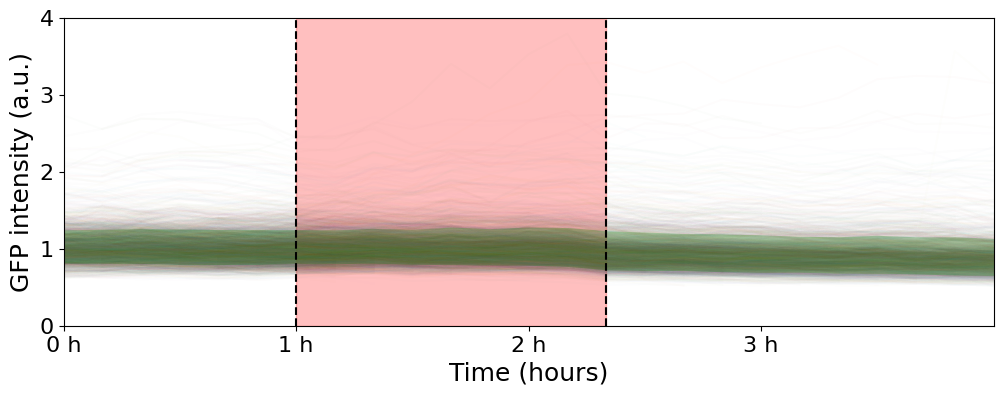

In [32]:
def plot_gfp_time(lineages_df, experiment_id, highlighted_ids, t_antibiotic_start, t_antibiotic_end):

      # Get the subset of the dataframe corresponding to the current experiment_id
    exp_df = lineages_df.loc[lineages_df["experiment_id"] == experiment_id]

      # Get the unique cell statuses for the current experiment_id
    cell_statuses = exp_df["cell_status"].unique()


      # Loop over each cell status and plot the corresponding line
    fig, ax = plt.subplots(figsize=(12, 4))
    ttimes=exp_df["time"].unique()
    #print(ttimes)
    all_timedata=dict()
    for t in ttimes:
        all_timedata[t]=[]
    for cell_status in cell_statuses:
        if 'Survived' in cell_status:
        # Get the subset of the dataframe corresponding to the current cell status
            cell_df = exp_df.loc[exp_df["cell_status"] == cell_status]
            print(cell_df.size,cell_status)
        # Plot the 'gfp' values over time for the current cell status
            for id, group_df in cell_df.groupby('id'):

                alpha = 0.01 if id not in highlighted_ids else 1.0
                ax.plot(group_df["time"], group_df["gfp"],  alpha=alpha)
                for t,d in zip(group_df["time"], group_df["gfp"]):
                    all_timedata[t].append(d)
          # Plot the 'gfp' values over time for the current cell status
          #ax.plot(cell_df["time"], cell_df["gfp"], color=colors[cell_status], label=cell_status, alpha=0.1)

          # Plot a scatter point at each division event
            #division_times = cell_df.loc[cell_df["division"], "time"]
            #division_gfps = cell_df.loc[cell_df["division"], "gfp"]
            #ax.scatter(division_times, division_gfps, color=colors[cell_status], s=30, marker="o", alpha=0.5)
    #### plot mean and sd
    tmeans=[]
    tsds=[]
    for t in ttimes:
        tmeans.append(np.mean(all_timedata[t]))
        tsds.append(np.std(all_timedata[t]))
    tmeans=np.array(tmeans)
    tsds=np.array(tsds)
    plt.fill_between(ttimes,tmeans-tsds,tmeans+tsds,zorder=2,lw=0,color='g',alpha=0.25)



      # Set the axis limits, tick positions, and labels
    xlim = (0, lineages_df["time"].max())
    xticks = np.arange(0, xlim[1], 60)
    ax.set_xlim(*xlim)
    ax.set_xticks(xticks)
    ax.set_ylim([0, 4])
    ax.set_xlim([0, xlim[1]])
    ax.set_xticklabels(["{} h".format(int(x / 60)) for x in xticks])
    ax.set_xlabel("Time (hours)", fontsize=18)
    ax.set_ylabel("GFP intensity (a.u.)", fontsize=18)

    ax.axvline(x=t_antibiotic_start, linestyle='--', color='black')
    ax.axvline(x=t_antibiotic_end, linestyle='--', color='black')
    ax.axvspan(xmin=t_antibiotic_start,xmax=t_antibiotic_end,ymin=0,ymax=1,color='red',alpha=0.25)
      #ax.legend()

    ax.tick_params(axis='both', labelsize=16)

      #plt.show()

t_antibiotic_start=60
t_antibiotic_end=140
highlighted_ids=[] #['xy28_1_20.032-44.000', 'xy44_1_20.058-44.000', 'xy02_1_20.038-44.000','xy21_1_20.027-44.000']
plot_gfp_time(lineages_processed_df, 'Plasmid', highlighted_ids, t_antibiotic_start, t_antibiotic_end)
out_fig_name=fig_path+'sFig-6A.pdf'
print("Saving fig as: \n",out_fig_name)
plt.savefig(out_fig_name,bbox_inches = 'tight',pad_inches = 0.1)


### 6B

This code defines a function **plot_gfp_dist()** that takes in a DataFrame lineages_df and an experiment_id. The function extracts the subset of the DataFrame corresponding to the provided experiment_id and computes the differences in GFP between consecutive time points for each ID. It then plots the distribution of GFP differences as a histogram using Seaborn's histplot() function. The x-axis represents the difference in GFP between consecutive time points (ΔGFP), while the y-axis represents the density of the data. A vertical line is drawn at the zero point to indicate where the distribution is centered. The resulting plot shows the distribution of changes in GFP intensity over time for cells in the selected experiment.

Saving fig as: 
 /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/SuppFigures/sFig-6B.pdf


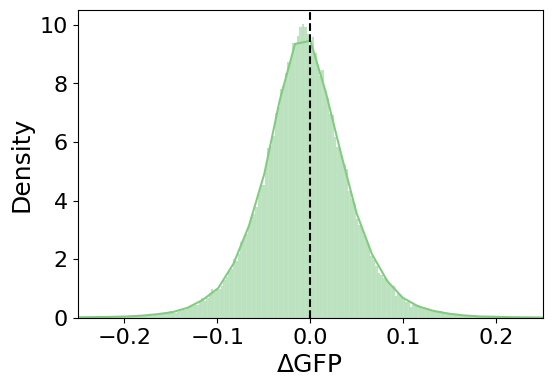

In [33]:


def plot_gfp_dist(lineages_df, experiment_id):
    # Get the subset of the dataframe corresponding to the current experiment_id
    t_antibiotic_end=140
    exp_df = lineages_df.loc[lineages_df["experiment_id"] == experiment_id] # & (lineages_df["time"] > t_antibiotic_start) & (lineages_df["time"] < t_antibiotic_end)

    # Get the unique IDs
    ids = exp_df["id"].unique()

    # Compute the differences in GFP between consecutive time points for each ID
    gfp_diffs = []
    for id in ids:
        id_df = exp_df.loc[exp_df["id"] == id]
        gfp_diff = id_df["gfp"].diff()
        gfp_diffs.extend(gfp_diff[1:].tolist())

    # Plot the distribution of GFP differences
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.histplot(gfp_diffs, kde=True, stat='density', ax=ax, color='#82CC82', edgecolor=dark_blue)
    ax.set_xlabel('ΔGFP', fontsize=18)
    ax.set_ylabel('Density', fontsize=18)
    #ax.set_title('Distribution of GFP differences', fontsize=18)
    ax.set_xlim([-0.25, 0.25])
    ax.tick_params(axis='both', labelsize=16)

    ax.axvline(x=0, linestyle='--', color='black')

    #plt.show()


plot_gfp_dist(lineages_processed_df, 'Plasmid')
out_fig_name=fig_path+'sFig-6B.pdf'
print("Saving fig as: \n",out_fig_name)
plt.savefig(out_fig_name,bbox_inches = 'tight',pad_inches = 0.1)

## Figure S7

The function **plot_status_time()** loops over each unique 'cell_status' and plots the mean and standard deviation of a metric ('gfp', 'length', 'ds_red') for each 'id' of that 'cell_status'. The plot is generated by looping over each 'cell_status' and creating a pivoted dataframe, where each column corresponds to a different 'id' and each row corresponds to a different timepoint. The mean and standard deviation of each metric across all lineages are calculated for each timepoint.

In [34]:
def plot_status_time(lineages_df, metric, this_experiment, this_ylim, t_antibiotic_start, t_antibiotic_end):
    # Get the subset of the dataframe corresponding to the experiment ID
    exp_df = lineages_df.loc[lineages_df["experiment_id"] == this_experiment]

    # Define the x-axis range and tick positions
    xlim = (0, exp_df["time"].max() + 10)
    xticks = np.arange(0, xlim[1], 60)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 4))

    # Define the colors for each cell status
    colors = {
          "Not filamented - Survived": dark_blue,
          "Not filamented - Not survived": dark_orange,
          "Filamented - Survived": light_blue,
          "Filamented - Not survived": light_orange
        }

    # Loop over each cell status
    for cell_status in exp_df["cell_status"].unique():
        # Get the subset of the dataframe corresponding to the current cell status
        cell_df = exp_df.loc[exp_df["cell_status"] == cell_status]

        # Pivot the dataframe to get a single column for each lineage
        pivoted_df = cell_df.pivot_table(index="time", columns="id", values=metric)

        # Calculate the mean of the metric's values across all lineages at each timepoint
        mean_values = pivoted_df.mean(axis=1)

        # Calculate the standard deviation of the metric's values across all lineages at each timepoint
        std_values = pivoted_df.std(axis=1, skipna=True)

        if metric=='length':
          mean_values=mean_values/px2um
          std_values=std_values/px2um

        # Plot the mean values over time with error bars
        ax.plot(mean_values.index, mean_values.values, color=colors[cell_status], label="{}".format(cell_status))
        ax.fill_between(mean_values.index, mean_values - std_values, mean_values + std_values, color=colors[cell_status], alpha=0.3)

    ax.set_xlim(*xlim)

    if metric=='ds_red':
      ax.set_xlabel("Time (hours)", fontsize=18)
      ax.set_xticks(xticks)
      ax.set_xticklabels(["{} h".format(int(x / 60)) for x in xticks])
    else:
      ax.set_xticks([])


    ax.tick_params(axis='both', labelsize=16)
    if this_experiment == 'Plasmid':
      lbl_experiment='MG:pBGT'
    else:
      lbl_experiment='MG/GT'

    #ax.set_title(lbl_experiment, fontsize=18)

    if metric=='gfp':
      ax.legend(fontsize=14)
      ax.set_ylabel('GFP intensity (a.u.)', fontsize=18)
    elif metric=='length':
      ax.set_ylabel('Cell length (µm)', fontsize=18)
    else:
      ax.set_ylabel(metric, fontsize=18)
    ax.set_ylim(this_ylim)

    ax.axvline(x=t_antibiotic_start, linestyle='--', color='black')
    ax.axvline(x=t_antibiotic_end, linestyle='--', color='black')

    #plt.show()




Saving fig as: 
 /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/SuppFigures/sFig-7A_gfp.pdf
Saving fig as: 
 /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/SuppFigures/sFig-7B_length.pdf
Saving fig as: 
 /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/SuppFigures/sFig-7C_red.pdf


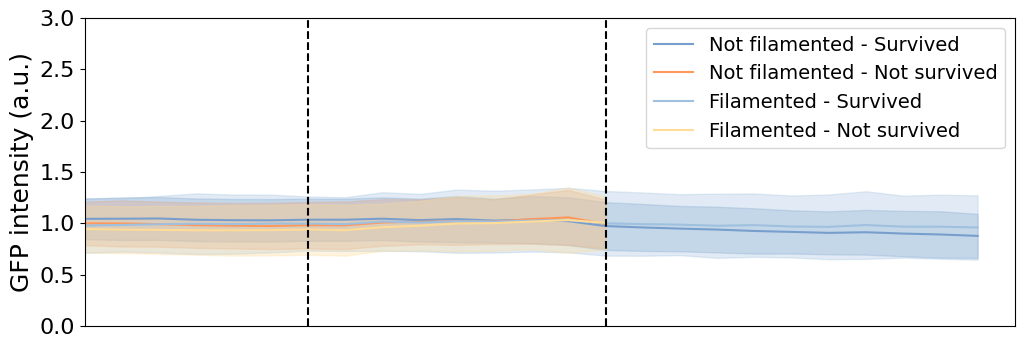

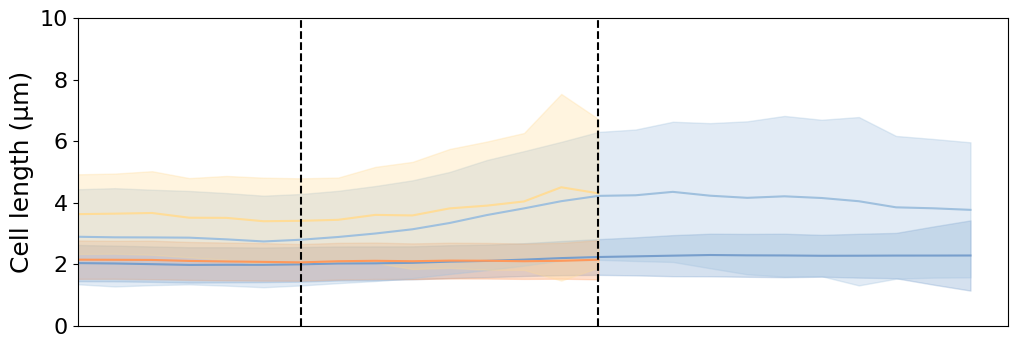

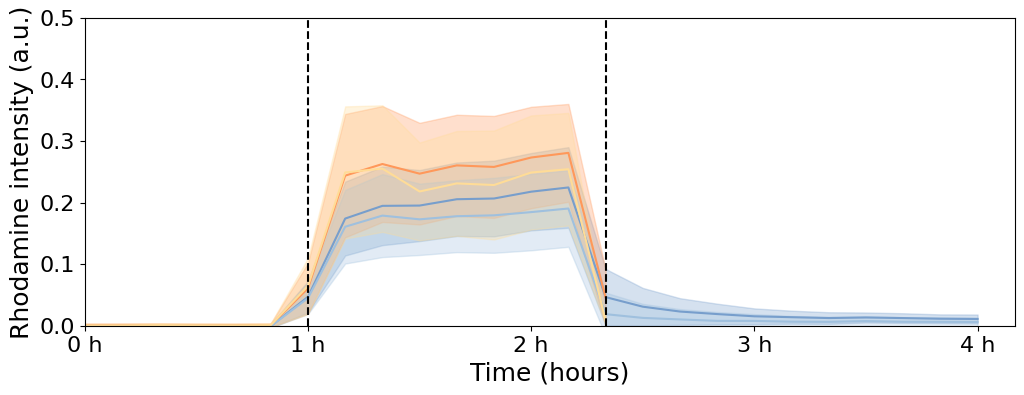

In [35]:
t_antibiotic_start_pbgt=60
t_antibiotic_end_pbgt=140


this_ylim=[0., 3]
plot_status_time(lineages_processed_df, 'gfp', 'Plasmid', this_ylim, t_antibiotic_start_pbgt, t_antibiotic_end_pbgt)
out_fig_name=fig_path+'sFig-7A_gfp.pdf'
print("Saving fig as: \n",out_fig_name)
plt.savefig(out_fig_name,bbox_inches = 'tight',pad_inches = 0.1)


this_ylim=[0., 10]
plot_status_time(lineages_processed_df, 'length', 'Plasmid', this_ylim, t_antibiotic_start_pbgt, t_antibiotic_end_pbgt)
out_fig_name=fig_path+'sFig-7B_length.pdf'
print("Saving fig as: \n",out_fig_name)
plt.savefig(out_fig_name,bbox_inches = 'tight',pad_inches = 0.1)

this_ylim=[0., 0.5]
plot_status_time(lineages_processed_df, 'ds_red', 'Plasmid', this_ylim, t_antibiotic_start_pbgt, t_antibiotic_end_pbgt)
out_fig_name=fig_path+'sFig-7C_red.pdf'
plt.ylabel("Rhodamine intensity (a.u.)")
print("Saving fig as: \n",out_fig_name)
plt.savefig(out_fig_name,bbox_inches = 'tight',pad_inches = 0.1)



## Figure S8

Saving fig as: 
 /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/SuppFigures/sFig-8A_gfp.pdf
Saving fig as: 
 /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/SuppFigures/sFig-8B_length.pdf
Saving fig as: 
 /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/SuppFigures/sFig-8C_red.pdf


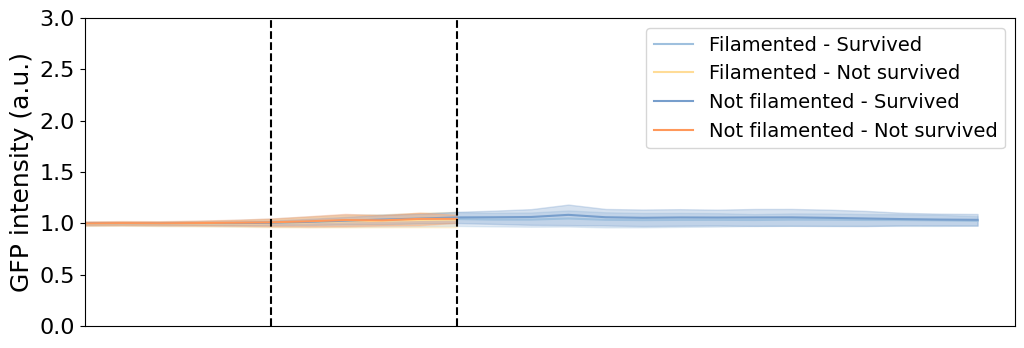

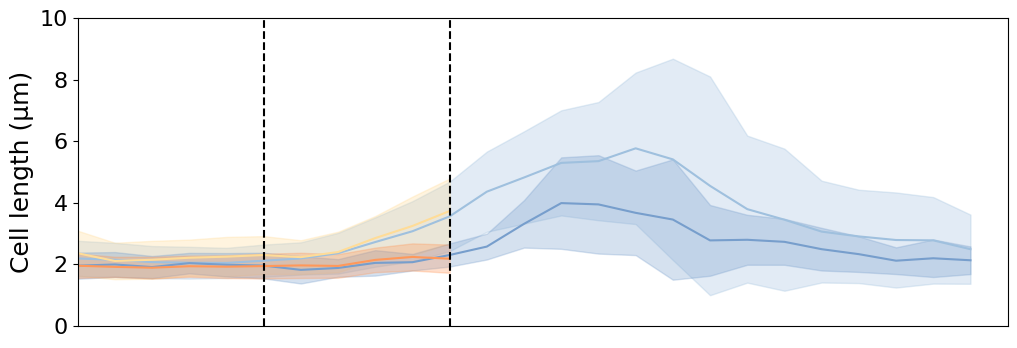

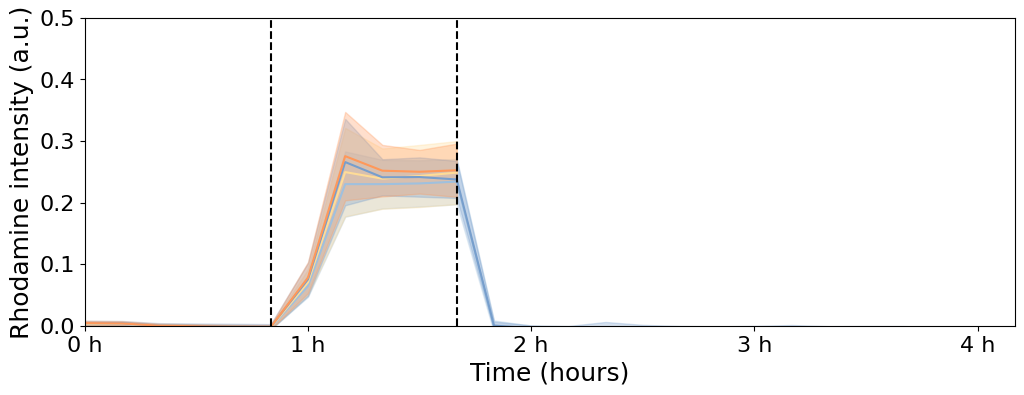

In [36]:

t_antibiotic_start_mggt=50
t_antibiotic_end_mggt=100


this_ylim=[0., 3]
plot_status_time(lineages_processed_df, 'gfp', 'Chromosome', this_ylim, t_antibiotic_start_mggt, t_antibiotic_end_mggt)
out_fig_name=fig_path+'sFig-8A_gfp.pdf'
print("Saving fig as: \n",out_fig_name)
plt.savefig(out_fig_name,bbox_inches = 'tight',pad_inches = 0.1)

this_ylim=[0., 10]
plot_status_time(lineages_processed_df, 'length', 'Chromosome', this_ylim, t_antibiotic_start_mggt, t_antibiotic_end_mggt)
out_fig_name=fig_path+'sFig-8B_length.pdf'
print("Saving fig as: \n",out_fig_name)
plt.savefig(out_fig_name,bbox_inches = 'tight',pad_inches = 0.1)

this_ylim=[0., 0.5]
plot_status_time(lineages_processed_df, 'ds_red', 'Chromosome', this_ylim, t_antibiotic_start_mggt, t_antibiotic_end_mggt)
plt.ylabel("Rhodamine intensity (a.u.)")
out_fig_name=fig_path+'sFig-8C_red.pdf'
print("Saving fig as: \n",out_fig_name)
plt.savefig(out_fig_name,bbox_inches = 'tight',pad_inches = 0.1)


In [37]:


def plot_gfp_time(lineages_df, experiment_id):

      # Get the subset of the dataframe corresponding to the current experiment_id
      exp_df = lineages_df.loc[lineages_df["experiment_id"] == experiment_id]

      # Get the unique cell statuses for the current experiment_id
      cell_statuses = exp_df["cell_status"].unique()

      # Define the colors for each cell status
      colors = {
          "Not filamented - Survived": "#43b284",
          "Not filamented - Not survived": "#fab255",
          "Filamented - Survived": "#0f7ba2",
          "Filamented - Not survived": "#dd5129"
      }


      xlim = (0, lineages_df["time"].max() + 10)
      xticks = np.arange(0, xlim[1], 120)

      # Loop over each cell status and plot the corresponding line
      fig, ax = plt.subplots(figsize=(12, 4))
      for cell_status in cell_statuses:
          # Get the subset of the dataframe corresponding to the current cell status
          cell_df = exp_df.loc[exp_df["cell_status"] == cell_status]

          # Plot the 'gfp' values over time for the current cell status
          ax.plot(cell_df["time"], cell_df["gfp"], color=colors[cell_status], label=cell_status, alpha=0.5)

          # Plot a scatter point at each division event
          division_times = cell_df.loc[cell_df["division"], "time"]
          division_gfps = cell_df.loc[cell_df["division"], "gfp"]
          ax.scatter(division_times, division_gfps, color=colors[cell_status], s=30, marker="o", alpha=0.5)

      # Set the axis limits, tick positions, and labels
      ax.set_xlim(*xlim)
      ax.set_xticks(xticks)
      ax.set_xticklabels(["{} h".format(int(x / 60)) for x in xticks])
      ax.set_xlabel("Time", fontsize=18)
      ax.set_ylabel("GFP", fontsize=18)
      ax.legend()

      plt.show()
#plot_gfp_time(lineages_processed_df, 'Plasmid')


## Figure S9

This code defines a function **plot_elongation_rates()** that takes in a DataFrame of lineage data, a timepoint at which antibiotic treatment starts, and conversion factors for frames to minutes and pixels to micrometers. The function generates two violin plots of elongation rates for cells that did or did not survive antibiotic treatment, separately for each experiment. The elongation rates are calculated as the difference in length between consecutive timepoints, divided by the frame-to-minute and pixel-to-micrometer conversion factors. The function returns a list of elongation rates for each experiment.

Saving fig as: 
 /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/SuppFigures/sFig-9.pdf
Chromosome: Survived vs Not survived
	T-statistic: -0.37029984927274284
	P-value: 0.7111938939350424
Plasmid: Survived vs Not survived
	T-statistic: 6.989221381580414
	P-value: 2.8467729561042045e-12
		Statistically significant!
ALL: Chromosome vs Plasmid
	T-statistic: 1.9492908616557771
	P-value: 0.05127268007704182


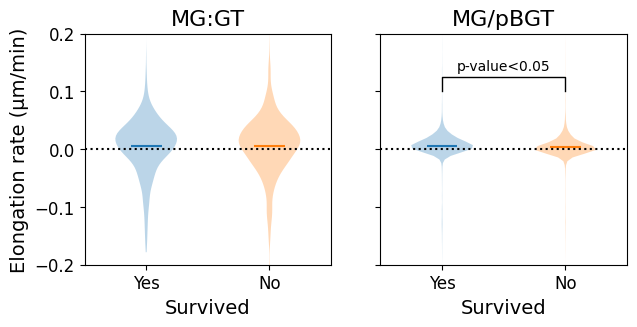

In [38]:
def plot_elongation_rates(lineages_df, t_antibiotic_start, frame2min, px2um):

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3),sharey=True)
    plt.rcParams.update({'font.size': 16})

    # Define the colors for each cell status
    colors = {
        "Not filamented - Survived": "#43b284",
        "Not filamented - Not survived": "#fab255",
        "Filamented - Survived": "#0f7ba2",
        "Filamented - Not survived": "#dd5129"
    }

    exp_elongation_rates = []

    for iexpe, experiment_id in enumerate(lineages_df["experiment_id"].unique()):
        # Get the subset of the dataframe corresponding to the current experiment_id
        exp_df = lineages_df.loc[(lineages_df["experiment_id"] == experiment_id) & (lineages_df["time"] < t_antibiotic_start)]

        # Get the subset of the dataframe corresponding to cells that survived or did not survive
        violins = []
        for i, survived in enumerate([True, False]):
            if survived:
                subset = exp_df.loc[exp_df["survived"] == 'Survived']
            else:
                subset = exp_df.loc[exp_df["survived"] == 'Not survived']

            # Sort the DataFrame by 'id' and 'time'
            subset = subset.sort_values(['id', 'time'])

            # Group the DataFrame by 'id'
            groups = subset.groupby('id')

            # Compute the difference in 'length' between consecutive 'time' values for each 'id'
            elongation_rates = groups['length'].diff() / frame2min / px2um

            # Ignore the 'time' where 'division' is True
            division_mask = groups['division'].diff() == False
            elongation_rates = elongation_rates[division_mask].dropna()

            # Create a violin plot for the elongation rate
            violin = axs[iexpe].violinplot(elongation_rates, positions=[i], showmeans=True, showextrema=False)
            #violin["cmeans"].set_color(colors[survived])

            #violin["cmeans"].set_color(colors[subgroup])
            violins.append(violin)

            exp_elongation_rates.append(elongation_rates)

        axs[iexpe].set_xlim(-0.5, 1.5)
        axs[iexpe].set_xticks([0, 1])
        axs[iexpe].set_xticklabels(['Yes', 'No'])#, fontsize=14)
        axs[iexpe].set_xlabel('Survived', fontsize=14)

        axs[iexpe].axhline(y=0, linestyle='dotted', color='black')

        if experiment_id == 'Plasmid':
            lbl_experiment = 'MG/pBGT'
        else:
            lbl_experiment = 'MG:GT'
        axs[iexpe].set_title(lbl_experiment, fontsize=16)

        if iexpe == 0:
            axs[iexpe].set_ylabel("Elongation rate (µm/min)", fontsize=14)
        #else:
            #axs[iexpe].set_yticks([])
        axs[iexpe].set_ylim(-.2, .2)
        axs[iexpe].tick_params(axis='both', labelsize=12)

    #plt.show()


    return exp_elongation_rates



t_antibiotic_start=60
exp_elongation_rates=plot_elongation_rates(lineages_processed_df, t_antibiotic_start, frame2min, px2um)
x1, x2 = 0, 1
y=0.1
h=0.025
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c='k')
plt.text((x1+x2)*.5, y+h*1.25, "p-value<0.05", ha='center', va='bottom', color='k',fontsize=10)

out_fig_name=fig_path+'sFig-9.pdf'
print("Saving fig as: \n",out_fig_name)
plt.savefig(out_fig_name,bbox_inches = 'tight',pad_inches = 0.1)

print('Chromosome: Survived vs Not survived')
t_statistic, p_value = ttest_ind(exp_elongation_rates[0], exp_elongation_rates[1])
print("\tT-statistic:", t_statistic)
print("\tP-value:", p_value)
if(p_value<0.05):
  print("\t\tStatistically significant!")

print('Plasmid: Survived vs Not survived')
t_statistic, p_value = ttest_ind(exp_elongation_rates[2], exp_elongation_rates[3])
print("\tT-statistic:", t_statistic)
print("\tP-value:", p_value)
if(p_value<0.05):
  print("\t\tStatistically significant!")


pbgt_elongation_rates=pd.concat([exp_elongation_rates[0], exp_elongation_rates[1]], axis=0, ignore_index=True)
mggt_elongation_rates=pd.concat([exp_elongation_rates[2], exp_elongation_rates[3]], axis=0, ignore_index=True)


print('ALL: Chromosome vs Plasmid')
t_statistic, p_value = ttest_ind(pbgt_elongation_rates, mggt_elongation_rates)
print("\tT-statistic:", t_statistic)
print("\tP-value:", p_value)
if(p_value<0.05):
  print("\t\tStatistically significant!")

## Figure S10


The function **get_surv_rates_mggt()** takes a dataframe of cell data (status_time_df) and calculates the survival rates for each combination of time and GFP bin for cells with experiment_id "Chromosome". The function filters the dataframe based on the experiment_id, defines the time steps to plot, and normalizes the GFP values. The survival rates are calculated by grouping cells based on whether they survived and the GFP bin they fall into. The resulting survival rates are normalized by the survival rates at a specified time point. The function then crops the survival rate array to include only GFP bins within the specified range, calculates the means of the cropped sections, and inserts them as the first and last rows of the cropped array. The function returns the cropped survival rate array and the corresponding GFP bins.

In [39]:

def get_surv_rates_mggt(status_time_df):

  experiment_id='Chromosome'
  gfp_low=0.1
  gfp_high=.35
  nbins=40

  # Filter for experiment_id
  df = status_time_df[status_time_df['experiment_id'] == experiment_id].copy()

  normalize_time=df.antibiotic_start_time.unique().item()

  # Define the time steps to plot
  times = np.sort(df['time'].unique())
  max_gfp=df['gfp_first'].max()
  min_gfp=df['gfp_first'].min()

  df['gfp_first'] = (df['gfp_first']-min_gfp)/(max_gfp-min_gfp)
  min_gfp=df['gfp_first'].min()
  max_gfp=df['gfp_first'].max()
  gfp_bins = np.linspace(min_gfp, max_gfp, nbins)

  # Calculate the survival rates for each combination of time and GFP bin
  survival_counts = []
  for t in times:
      t_df = df[df['time'] == t]
      t_survived_counts = t_df[t_df['survived'] == 'Survived'].groupby(
          pd.cut(t_df['gfp_first'], gfp_bins)).size()

      if t==normalize_time:
          t_counts=t_survived_counts.values

      survival_counts.append(t_survived_counts.values)
  survival_counts = np.array(survival_counts).T

  # Normalize the survival rates by the survival rates at the specified time point
  survival_rates=[]
  for ti,t in enumerate(times):
      this_surv_rate=np.nan_to_num(survival_counts[:,ti] / t_counts)
      survival_rates.append(this_surv_rate)
  surv_rate_df=100*pd.DataFrame(survival_rates).T

  #Only consider relevant bins
  cropped_bins1=gfp_bins[gfp_bins<gfp_low]
  cropped_bins2=gfp_bins[gfp_bins>gfp_high]
  cropped_bins=(np.concatenate((cropped_bins1, cropped_bins2)))
  matching_indices = np.where(np.in1d(gfp_bins,cropped_bins))[0]
  N=len(cropped_bins1)
  M=len(cropped_bins2)

  # Crop the array
  surv_arr = surv_rate_df[N:-M]

  # Calculate the means of the cropped sections
  first_mean = np.mean(surv_rate_df[:N], axis=0)
  last_mean = np.mean(surv_rate_df[-M:], axis=0)

  # Insert the means as the first and last rows of the cropped array
  surv_arr = np.vstack([first_mean, surv_arr, last_mean])

  gfp_bins_cropped=gfp_bins[np.setdiff1d(np.arange(0, len(gfp_bins)), matching_indices)]

  return surv_arr, gfp_bins_cropped




The function **plot_survival_heatmap_gfp()** takes in a survival rate array and a GFP bin array and generates a heatmap plot where each row represents a different GFP intensity bin and each column represents a different time point. The color of each cell in the heatmap corresponds to the survival rate for the corresponding GFP bin and time point. The y-axis of the plot is labeled with the normalized fluorescent intensity of the cells.

The **plot_survival_histogram_gfp()** function takes survival rates and GFP bins as inputs and creates a histogram plot showing the final survival rates for each GFP bin. The plot is colored according to the final survival rates, with a colormap specified by cmap. The function also has an optional argument t_surv, which specifies the time point at which to calculate the final survival rates. If t_surv is not specified, the final survival rates are calculated at the last time point.

In [41]:
def plot_survival_histogram_gfp(surv_rates, gfp_bins, t_surv=-1,  vmin=0, vmax=100):
    nbins = len(gfp_bins)

    # Define the color stops and corresponding colors for the gradient
    color_stops = [0., 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    colors_list = ['#E06800', dark_orange, light_orange, 'white', light_blue, dark_blue, '#3B638C']

    # Create the colormap
    colormap = colors.LinearSegmentedColormap.from_list("", list(zip(color_stops, colors_list)))

    # Calculate the final survival rates for each GFP bin
    final_rates = surv_rates[:, t_surv]
    dy = gfp_bins[2] - gfp_bins[1]

    # Create the histogram plot
    fig, ax = plt.subplots(figsize=(4, 5.9))
    fig.set_facecolor('white')

    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    #cmap = plt.cm.get_cmap(cmap)
    cols = colormap(norm(final_rates[:-1]), alpha=1.0)
    rects = ax.barh(gfp_bins, final_rates[:-1], align='center', edgecolor='grey', height=dy, color=cols)

    # Set y-axis ticks and labels to the GFP bins
    ax.set_yticks(gfp_bins)
    ax.set_ylim([gfp_bins[0]-dy/2, gfp_bins[-1]+dy/2])
    ax.set_yticklabels([])
    #ax.set_yticklabels([f'<{gfp_bins[0]:.2f}'] + [f'{g:.2f}' for g in gfp_bins[1:-1]] + [f'>{gfp_bins[-1]:.2f}'], fontsize=16)
    #ax.set_ylabel('GFP', fontsize=18)

    # Set x-axis limits and tick labels
    ax.set_xlabel('Cells alive (%)', fontsize=18)
    ax.set_xlim([vmin, vmax])
    ax.tick_params(axis='both', labelsize=16)

    #plt.show()
    plt.tight_layout()
    #plt.show()
    return fig

In [74]:
 def plot_survival_heatmap_gfp(surv_rates, gfp_bins, t_antibiotic, vmin=0, vmax=100):
    # Calculate the number of GFP bins
    nbins = len(gfp_bins)

    # Define the color stops and corresponding colors for the gradient
    color_stops = [0., 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    colors_list = ['#E06800', dark_orange, light_orange, 'white', light_blue, dark_blue, '#3B638C']

    # Create the colormap
    colormap = colors.LinearSegmentedColormap.from_list("", list(zip(color_stops, colors_list)))

    # Create the heatmap plot
    fig, ax = plt.subplots(figsize=(8, 7.2))
    fig.set_facecolor('white')

    heatmap = sns.heatmap(surv_rates, cmap=colormap, ax=ax, cbar_kws={'label': 'Survival Rate', 'orientation': 'horizontal', 'location':'top'}, vmin=vmin, vmax=vmax)
    heatmap.invert_yaxis()
    ax.set_xlabel('Time (minutes)', fontsize=18)

    # Set x-axis limits and tick labels
    ax.set_xlim((t_antibiotic[0]/frame2min, 24))
    ax.set_xticks(np.linspace(t_antibiotic[0]/frame2min,25,4))
    ax.set_xticklabels([f'{int(tick)}' for tick in np.linspace(0,180,4)], fontsize=16,rotation=0)


    # Set y-axis ticks and labels to the GFP bins
    yticks = np.arange(nbins) + 1.5
    yticklabels = [f'<{gfp_bins[0]:.2f}']
    yticklabels += [f'{g:.2f}' for g in gfp_bins[1:-1]]
    yticklabels += [f'>{gfp_bins[-1]:.2f}']
    dy=(yticks[2]-yticks[1])
    ax.set_yticks(yticks-dy)
    ax.set_ylim([0, yticks[-1]-dy/2])
    ax.set_yticklabels(yticklabels, rotation=0, fontsize=16)
    ax.set_ylabel('Normalized GFP intensity', fontsize=18)

    # Add color bar for heatmap
    cbar = heatmap.collections[0].colorbar
    cax = cbar.ax  # get the ax of the colorbar
    pos = cax.get_position()  # get the original position

    cax.set_position([pos.x0+pos.width * 0.35, pos.y0, pos.width * 0.65, pos.height])  # set a new position
    cax.set_frame_on(True)
    cbar.ax.set_xlim([40,100])



    cbar.ax.tick_params(labelsize=16)  # set font size of tick labels
    cbar.ax.set_xlabel('Cells alive (%)', fontsize=18)  # set font size of the label
    cbar.ax.tick_params(labelsize=16, length=0) # Remove tick marks
    cbar.ax.xaxis.set_ticks_position('top') # Set ticks to be on the top axis
    cbar.ax.xaxis.set_label_position('top') # Set label to be on the top axis
    for spine in cax.spines.values():  # show the colorbar frame again
        spine.set(visible=True, lw=.8, edgecolor='black')

    # arrows
    ax.annotate('', xy=(-0.01, 1.05), xycoords='axes fraction',
            xytext=(0.325, 1.05), textcoords='axes fraction',
            va ='center', ha='center',
            arrowprops=dict(facecolor='black', shrinkA=5, shrinkB=5,arrowstyle='<|-|>',lw=2))
    plt.annotate('AMP', xy=(0,1.1), xytext=(0.12,1.075),xycoords='axes fraction',
                 weight='bold',fontsize=16,
             textcoords='axes fraction')
    # ax.annotate('', xy=(0, 1.0), xycoords='axes fraction',
    #             xytext=(0.,1.1), textcoords='axes fraction',
    #             arrowprops={'arrowstyle': '-', 'ls': 'dashed'}, va='center')

    #### the dashed lines
    x0=t_antibiotic[0]/frame2min
    ax.annotate('', xy=(x0, yticks[-1]-dy/2), xycoords='data',
                xytext=(x0,yticks[-1]+dy/2), textcoords='data',zorder=2,
                arrowprops={'arrowstyle': '-', 'ls': 'dashed'}, va='center')
    x0=t_antibiotic[1]/frame2min
    ax.annotate('', xy=(x0, yticks[-1]-dy/2), xycoords='data',
                xytext=(x0,yticks[-1]+dy/2), textcoords='data',zorder=2,
                arrowprops={'arrowstyle': '-', 'ls': 'dashed'}, va='center')

    # Show the plot
    #plt.tight_layout()
    #plt.show()
    return fig


### MG:GT

In [42]:
# Define the file path to the processed lineages data
lineages_file = data_path + "processed_lineages.csv"

# Load the processed lineages data into a pandas dataframe
lineages_raw_df = pd.read_csv(lineages_file)

# Assign categorical variables to the "filamented_id", "filamented_at_time", and "survived" columns
lineages_processed_df = lineages_raw_df.assign(
    filamented_id = pd.Categorical(
        lineages_raw_df.filamented_id,
        categories=[False, True],
        ordered=False
    ).rename_categories(["Not filamented", "Filamented"]),
    filamented_at_time = pd.Categorical(
        lineages_raw_df.filamented_at_time,
        categories=[False, True],
        ordered=False
    ).rename_categories(["Not filamented", "Filamented"]),
    survived = pd.Categorical(
        lineages_raw_df.survived,
        categories=[False, True],
        ordered=False
    ).rename_categories(["Not survived", "Survived"]),

    # Combine "filamented_id" and "survived" columns into a new "cell_status" column
    cell_status = (
        lineages_raw_df["filamented_id"].map({
            False: "Not filamented",
            True: "Filamented"
        }) + " - " +
        lineages_raw_df["survived"].map({
            False: "Not survived",
            True: "Survived"
        })
    ).astype("category")
)

#display(lineages_processed_df.head(2))

# Group by "experiment_id", "id", and "time", and apply the grouping to the dataframe
status_time_df_a = (lineages_processed_df
                  .loc[:, ['experiment_id', 'id', 'time']]
                  .groupby(['experiment_id', 'id'], group_keys=False)
                  .apply(lambda x: x)
                    )

# Merge the processed lineages dataframe with the grouped dataframe on "experiment_id", "id", and "time"
status_time_df=(status_time_df_a.merge(lineages_processed_df, on=['experiment_id', 'id', 'time'], how='left')
                  .rename(columns={'filamented_at_time': 'cell_status_at_time'})

                  # Forward fill and backward fill any missing data
                  .fillna(method='ffill')
                  .fillna(method='bfill')

                  # Assign categorical variables to the "cell_status_at_time" column
                  .assign(cell_status_at_time=lambda x: x['cell_status_at_time'].astype(str)
                          .fillna('Dead')
                          .astype('category')
                          .cat.set_categories(['Not filamented', 'Filamented', 'Dead'], ordered=True),
                          )
                   )

# Display the first two rows of the final status_time dataframe
display(status_time_df.head(2))


,experiment_id,id,time,division,cell_status_at_time,over_ds_red_threshold_at_time,filamented_id,survived,length,gfp,...,antibiotic_end_time,length_mean,gfp_mean,ds_red_mean,filamentation_threshold,ds_red_threshold,time_first,time_last,gfp_first,cell_status
0,Chromosome,xy01_1_10.008-34.000,0,False,Not filamented,False,Filamented,Survived,25.849646,0.984079,...,100,26.032382,122.053191,107.727847,38.22991,146.11125,0,110,0.984079,Filamented - Survived
1,Chromosome,xy01_1_10.008-34.000,10,True,Filamented,False,Filamented,Survived,41.415166,0.985546,...,100,26.032382,122.053191,107.727847,38.22991,146.11125,0,110,0.984079,Filamented - Survived


<ipython-input-39-2c1ee8255543>:39: RuntimeWarning: invalid value encountered in divide
  this_surv_rate=np.nan_to_num(survival_counts[:,ti] / t_counts)


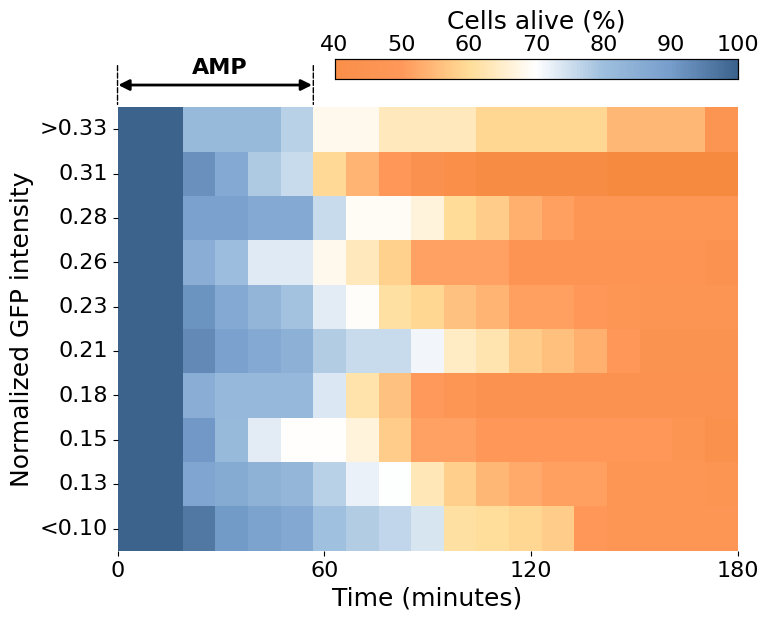

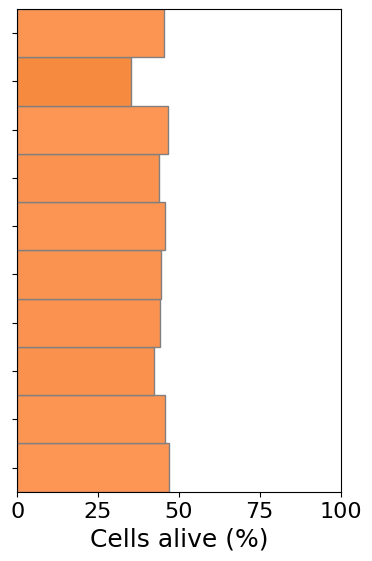

In [75]:

# Calculate the survival rates and GFP bins using the status_time_df
surv_rates_mggt, gfp_bins_mggt = get_surv_rates_mggt(status_time_df)

# Define the time at which antibiotics were administered
t_antibiotic_mggt = [60, 120] #in minutes

# Plot the heatmap of survival rates against GFP intensity
fig=plot_survival_heatmap_gfp(surv_rates_mggt, gfp_bins_mggt, t_antibiotic_mggt, vmin=0, vmax=100)
figname=fig_path+"sFig-10A.pdf"
plt.savefig(figname,bbox_inches = 'tight',pad_inches = 0.1)

plt.show()
# Plot the histogram of final survival rates against GFP intensity
fig=plot_survival_histogram_gfp(surv_rates_mggt, gfp_bins_mggt, vmin=0, vmax=100)
figname=fig_path+"sFig-10B.pdf"
plt.savefig(figname,bbox_inches = 'tight',pad_inches = 0.1)

plt.show()

## Figure S11

This function, **plot_gfp_survival()**, takes a pandas DataFrame __lineages_df__, an __experiment_id__, and an optional time __t__ as input, and generates a bar plot of the survival rate of cells as a function of their GFP intensity.



<ipython-input-44-13e9d7271787>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  exp_df.loc[:, "survived"] = exp_df["survived"].map({"Survived": True, "Not survived": False})


Saving fig as: 
 /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/SuppFigures/sFig-11B.pdf


<ipython-input-44-13e9d7271787>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  exp_df.loc[:, "survived"] = exp_df["survived"].map({"Survived": True, "Not survived": False})


Saving fig as: 
 /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/SuppFigures/sFig-11A.pdf


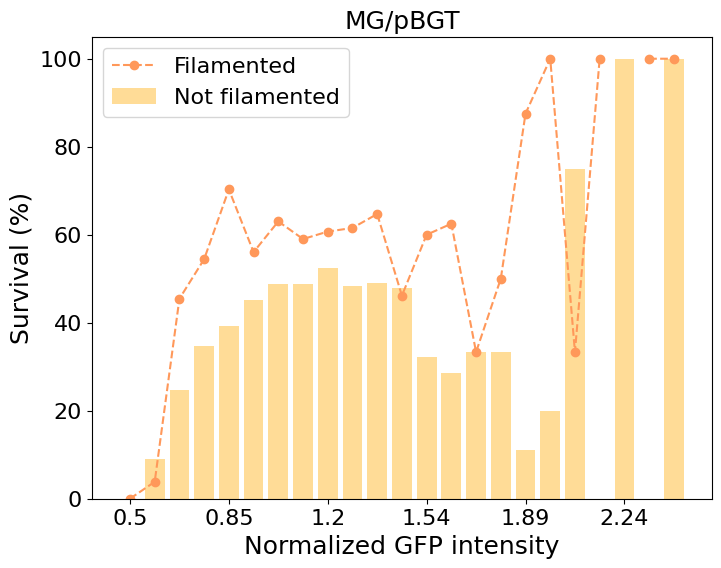

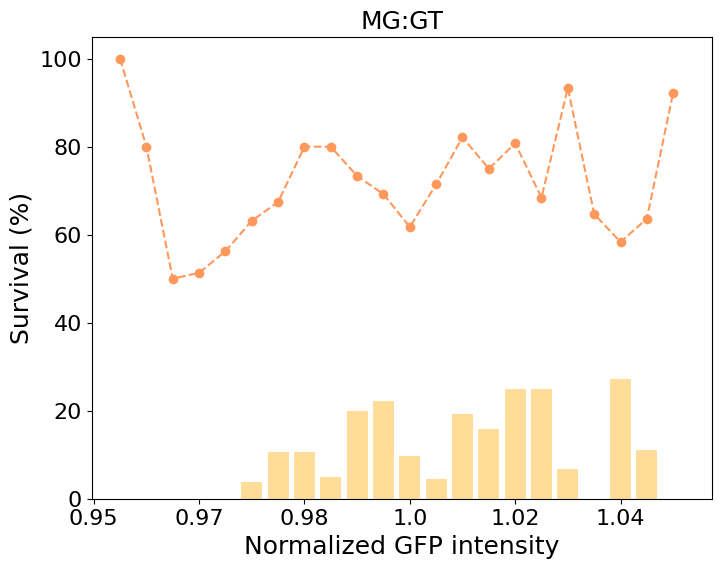

In [44]:
def plot_gfp_survival(lineages_df, experiment_id, t=60):

    # Get the subset of the dataframe corresponding to the current experiment_id
    exp_df = lineages_df.loc[lineages_df["experiment_id"] == experiment_id].copy()

    # Map the "survived" column to a boolean value
    exp_df.loc[:, "survived"] = exp_df["survived"].map({"Survived": True, "Not survived": False})
    exp_df.loc[:, "survived_bool"] = exp_df["survived"].astype(bool)

    # Bin the GFP values into 20 equally spaced bins
    nbins=24


    if experiment_id=='Chromosome':
      gfp_bins=np.linspace(0.95, 1.05, nbins)
    else:
      gfp_bins=np.linspace(0.5, 2.5, nbins)


    bin_labels = np.arange(len(gfp_bins)-1)

    # Compute the survival rate for each bin for cells that didn't filament
    surv_rates_not_filamented = []
    for i in bin_labels:
        mask = (exp_df["gfp"].astype(float) >= gfp_bins[i]) & (exp_df["gfp"].astype(float) < gfp_bins[i+1]) & (exp_df["filamented_id"] == "Not filamented")
        surv_rate = 100*exp_df.loc[mask & (exp_df["time"] == t), "survived_bool"].mean()
        surv_rates_not_filamented.append(surv_rate)

    # Compute the survival rate for each bin for cells that filamented
    surv_rates_filamented = []
    for i in bin_labels:
        mask = (exp_df["gfp"].astype(float) >= gfp_bins[i]) & (exp_df["gfp"].astype(float) < gfp_bins[i+1]) & (exp_df["filamented_id"] == "Filamented")
        surv_rate = 100*exp_df.loc[mask & (exp_df["time"] == t), "survived_bool"].mean()
        surv_rates_filamented.append(surv_rate)

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(bin_labels, surv_rates_not_filamented, color=light_orange, width=0.8)
    #ax.bar(bin_labels+0.25, surv_rates_filamented, color=dark_orange, width=0.4)

    ax.plot(bin_labels, surv_rates_filamented, "o--", color=dark_orange)
    ax.set_xticks(bin_labels)
    ax.set_xticklabels(np.round(gfp_bins[:-1], decimals=2))
    ax.set_xlabel("Normalized GFP intensity", fontsize=18)
    ax.set_ylabel("Survival (%)", fontsize=18)
    ax.set_ylim([0, 105])
    ax.tick_params(axis="both", labelsize=16)

    # Add legend depending on the experiment ID
    if experiment_id=='Plasmid':
      plt.legend(["Filamented", "Not filamented"], fontsize=16, loc='upper left')

    if experiment_id == 'Plasmid':
      lbl_experiment='MG/pBGT'
    else:
      lbl_experiment='MG:GT'
    ax.set_title(lbl_experiment, fontsize=18)
    ax.set_xticks(bin_labels[::4])
#    plt.show()


    if experiment_id=='Plasmid':
      out_fig_name=fig_path+'sFig-11B.pdf'
    else:
      out_fig_name=fig_path+'sFig-11A.pdf'

    print("Saving fig as: \n",out_fig_name)
    plt.savefig(out_fig_name,bbox_inches = 'tight',pad_inches = 0.1)

plot_gfp_survival(lineages_processed_df, 'Plasmid')

plot_gfp_survival(lineages_processed_df, 'Chromosome')

## Figure S12

### PCA

This code performs principal component analysis (PCA) on DataFrame pca_cells_df and plots the cumulative explained variance ratio for each number of principal components. The explained variance ratio for each component is then obtained using the explained_variance_ratio_ attribute of the PCA object, and the cumulative explained variance ratio is calculated using np.cumsum(). Finally, the cumulative explained variance ratio is plotted against the number of components using plt.plot().

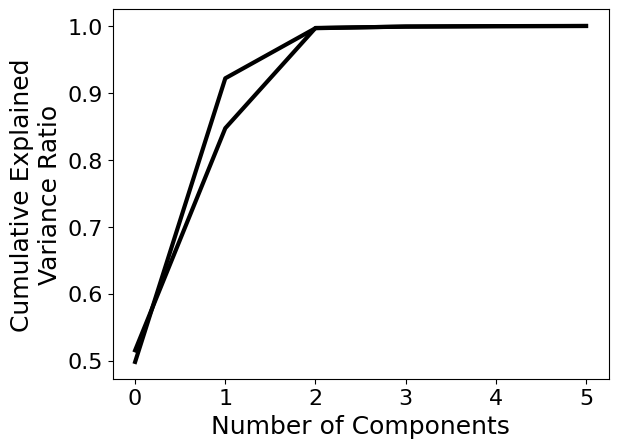

In [45]:


def plot_cummulative_pca(pca_cells_df, experiment_id):

  pca_cells_df['experiment_id'] = pca_cells_df['experiment_id'].replace({'Plasmid': 0, 'Chromosome': 1})

  # Get the subset of the dataframe corresponding to the current experiment_id
  pca_cells_df = pca_cells_df.loc[pca_cells_df["experiment_id"] == experiment_id]

  selected_columns = ['experiment_id', 'length_first', 'length_last', 'gfp_first', 'gfp_last', 'ds_red_first', 'ds_red_last', 'n_divisions', 'filamented_id', 'survived','time_since_last_division_to_experiment_start']
  pca_cells_df = pca_cells_df[selected_columns]
  pca_cells_df = pca_cells_df.dropna()

  pca_cells_df = pd.get_dummies(pca_cells_df, columns=['filamented_id', 'survived'])

  # Exclude any columns containing string values
  numerical_cols = [col for col in pca_cells_df.columns if pca_cells_df[col].dtype != 'object']
  pca_cells_df = pca_cells_df[numerical_cols]

  pca_variables = ['length_first', 'length_last', 'gfp_first', 'gfp_last', 'ds_red_first', 'ds_red_last']
  n_components = 6 #len(pca_variables)

  pca = PCA(n_components=n_components)
  pca.fit(pca_cells_df[numerical_cols])

  # Get the explained variance ratio
  explained_variance_ratio = pca.explained_variance_ratio_

  # Plot the cumulative explained variance
  cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
  plt.plot(cumulative_explained_variance_ratio, linewidth=3, color='k')
  plt.xlabel('Number of Components', fontsize=18)
  plt.ylabel('Cumulative Explained\nVariance Ratio', fontsize=18)
  plt.tick_params(axis='both', labelsize=16)
  #plt.show()

  out_fig_name=fig_path+'sFig-X.pdf'
  #print("Saving fig as: \n",out_fig_name)
  #plt.savefig(out_fig_name,bbox_inches = 'tight',pad_inches = 0.1)

  return pca

pca_pbgt=plot_cummulative_pca(cells_raw_df, 0)
pca_mggt=plot_cummulative_pca(cells_raw_df, 1)
plt.show()


The **plot_pca()** function takes a pandas dataframe (pca_cells_df) containing cell data for a given experiment (experiment_id) and performs a principal component analysis (PCA) on the numerical columns of the dataframe. The resulting two principal components are then plotted as a scatter plot, with each point colored according to the cell status (survived/not survived) and filamentation status (filamented/not filamented) of the corresponding cell.

Saving fig as: 
 /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/SuppFigures/sFig-12C.pdf
Saving fig as: 
 /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/SuppFigures/sFig-12A.pdf


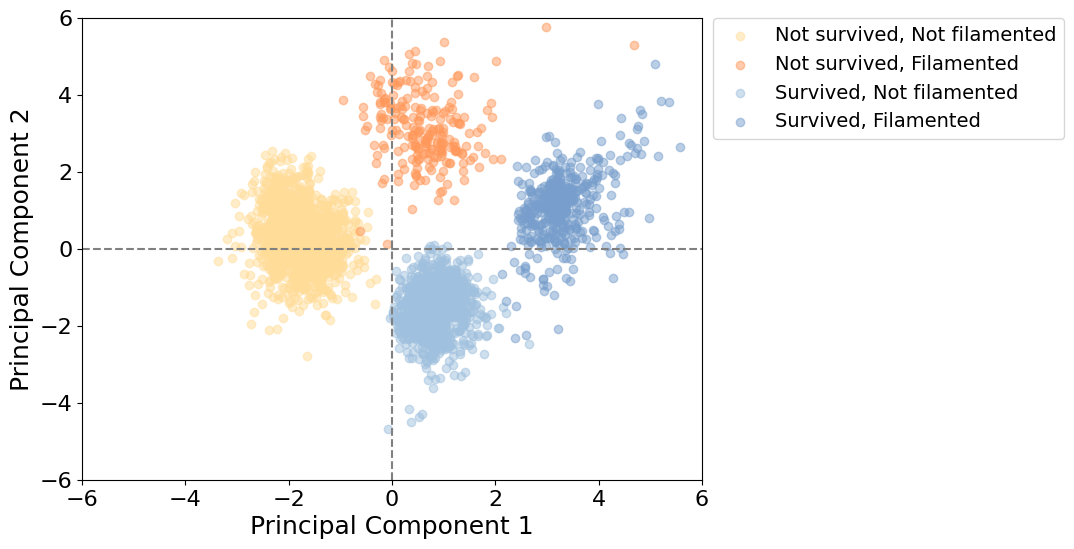

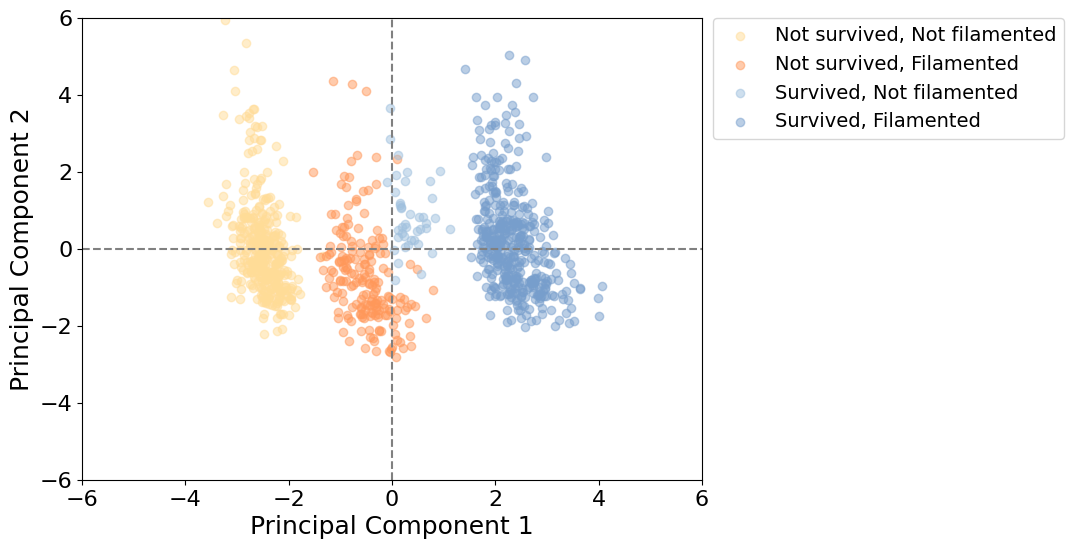

In [46]:
def plot_pca(pca_cells_df, experiment_id):
  # Replace the experiment_id strings with integer values for use in the PCA
  pca_cells_df['experiment_id'] = pca_cells_df['experiment_id'].replace({'Plasmid': 0, 'Chromosome': 1})

  # Get the subset of the dataframe corresponding to the current experiment_id
  pca_cells_df = pca_cells_df.loc[pca_cells_df["experiment_id"] == experiment_id]

  # Select only the relevant columns and drop any rows with missing values
  selected_columns = ['experiment_id', 'length_first', 'length_last', 'gfp_first', 'gfp_last', 'ds_red_first', 'ds_red_last', 'n_divisions', 'filamented_id', 'survived','time_since_last_division_to_experiment_start']
  pca_cells_df = pca_cells_df[selected_columns]
  pca_cells_df = pca_cells_df.dropna()

  # Convert categorical columns to one-hot encoded columns
  pca_cells_df = pd.get_dummies(pca_cells_df, columns=['filamented_id', 'survived'])

  # Exclude any columns containing string values
  numerical_cols = [col for col in pca_cells_df.columns if pca_cells_df[col].dtype != 'object']
  pca_cells_df = pca_cells_df[numerical_cols]

  # Define the variables to use in the PCA and the number of principal components to compute
  pca_variables = ['length_first', 'length_last', 'gfp_first', 'gfp_last', 'ds_red_first', 'ds_red_last']
  n_components = 2

  # Scale the data to have zero mean and unit variance
  scaler = StandardScaler()
  scaled_df = scaler.fit_transform(pca_cells_df)

  # Compute the principal components of the scaled data
  pca = PCA(n_components=n_components)
  pca_transformed = pca.fit_transform(scaled_df)

  # Create a scatter plot of the first two principal components, colored by survival and filamentation status
  fig, ax = plt.subplots(figsize=(8, 6))
  colors = {(False, False): light_orange, (False, True): dark_orange, (True, False): light_blue, (True, True): dark_blue}
  for survived in [0, 1]:
    for filamented in [0, 1]:
      indices = (pca_cells_df["survived_True"]==survived) & (pca_cells_df["filamented_id_True"]==filamented)
      status_pca_transformed = pca_transformed[indices]

      if survived:
          lbl='Survived, '
      else:
          lbl='Not survived, '
      if filamented:
          lbl+='Filamented'
      else:
          lbl+='Not filamented'

      ax.scatter(status_pca_transformed[:, 0], status_pca_transformed[:, 1], color=colors[(survived, filamented)], label=lbl, alpha=0.5)

  # Add axes labels and a legend to the plot
  ax.axhline(y=0, linestyle='--', color='gray')
  ax.axvline(x=0, linestyle='--', color='gray')
  ax.set_xlabel('Principal Component 1', fontsize=18)
  ax.set_ylabel('Principal Component 2', fontsize=18)
  ax.legend(fontsize=14, loc='upper right', bbox_to_anchor=(1.6, 1.02))
  ax.tick_params(axis='both', labelsize=16)
  ax.set_ylim([-6, 6])
  ax.set_xlim([-6, 6])
  #plt.show()

  if experiment_id==0:
    out_fig_name=fig_path+'sFig-12C.pdf'
  else:
    out_fig_name=fig_path+'sFig-12A.pdf'

  print("Saving fig as: \n",out_fig_name)
  plt.savefig(out_fig_name,bbox_inches = 'tight',pad_inches = 0.1)

  return pca

pca=plot_pca(cells_raw_df, 0)
pca=plot_pca(cells_raw_df, 1)


This code defines a function **plot_pca_loadings()** that takes a Pandas DataFrame __pca_cells_df__ and an experiment ID as input, and creates a heatmap of the principal component loadings for the specified experiment.

First, the function filters the input DataFrame to only include data for the specified experiment ID, and selects a subset of columns. The function then drops any rows with missing values and standardizes the remaining numerical columns using StandardScaler.

PCA is then performed on the standardized data using PCA from the scikit-learn library. The loadings matrix (i.e. the eigenvectors) is extracted using pca.components_.

Saving fig as: 
 /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/SuppFigures/sFig-12D.pdf
Saving fig as: 
 /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/SuppFigures/sFig-12B.pdf


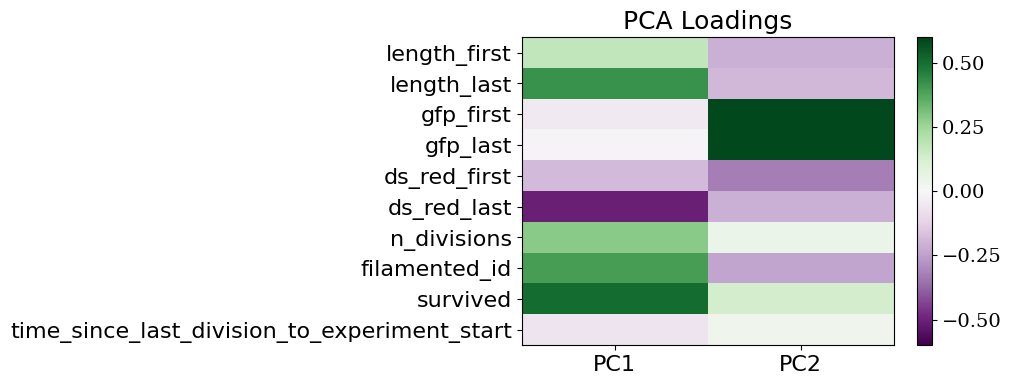

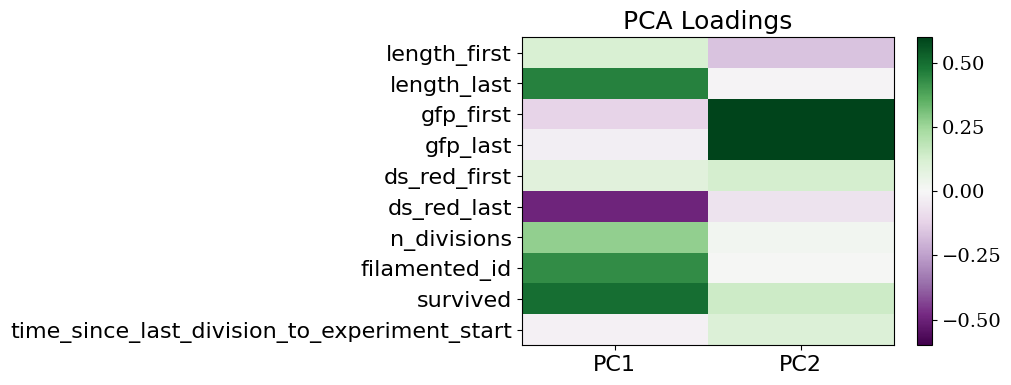

In [47]:

def plot_pca_loadings(pca_cells_df, experiment_id):

    # Replace 'Plasmid' and 'Chromosome' values in 'experiment_id' column with 0 and 1, respectively
    pca_cells_df['experiment_id'] = pca_cells_df['experiment_id'].replace({'Plasmid': 0, 'Chromosome': 1})

    # Get the subset of the dataframe corresponding to the current experiment_id
    pca_cells_df = pca_cells_df.loc[pca_cells_df["experiment_id"] == experiment_id]

    # Select columns to use for PCA and drop rows with missing values
    selected_columns = ['length_first', 'length_last', 'gfp_first', 'gfp_last', 'ds_red_first', 'ds_red_last', 'n_divisions', 'filamented_id', 'survived','time_since_last_division_to_experiment_start']
    pca_cells_df = pca_cells_df[selected_columns]
    pca_cells_df = pca_cells_df.dropna()

    # Exclude any columns containing string values
    numerical_cols = [col for col in pca_cells_df.columns if pca_cells_df[col].dtype != 'object']
    pca_cells_df = pca_cells_df[numerical_cols]

    # Set the number of principal components to 2
    n_components = 2

    # Scale the data using StandardScaler
    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(pca_cells_df)

    # Fit PCA with n_components=2
    pca = PCA(n_components=n_components)
    pca_transformed = pca.fit_transform(scaled_df)

    # Create labels for the principal components
    pc_labels = [f"PC{i}" for i in range(1, n_components+1)]

    # Get the loadings matrix (i.e., the eigenvectors)
    loadings = pca.components_.T

    # Plot the loadings as a heatmap
    fig, ax = plt.subplots(figsize=(6, 4))
    im = ax.imshow(loadings, cmap="PRGn", aspect="auto")

    # Set the y-ticks and labels to the column names of the original dataframe
    ax.set_yticks(np.arange(len(pca_cells_df.columns)))
    ax.set_yticklabels(pca_cells_df.columns, rotation=0)

    # Set the x-ticks and labels to the PC labels
    ax.set_xticks(np.arange(n_components))
    ax.set_xticklabels(pc_labels, fontsize=18)

    # Set the title and tick sizes
    ax.set_title("PCA Loadings", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)

    # Add a colorbar and set the tick labels
    cbar = fig.colorbar(im)
    cbar.set_ticks([-0.5, -0.25, 0, 0.25, 0.5])
    cbar.set_ticklabels(cbar.ax.get_yticklabels(), fontdict={'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 14})

    # Set the range of values shown in the colorbar
    im.set_clim(vmin=-0.6, vmax=0.6)

    #plt.show()


    if experiment_id==0:
      out_fig_name=fig_path+'sFig-12D.pdf'
    else:
      out_fig_name=fig_path+'sFig-12B.pdf'

    print("Saving fig as: \n",out_fig_name)
    plt.savefig(out_fig_name,bbox_inches = 'tight',pad_inches = 0.1)

plot_pca_loadings(cells_raw_df, 0)
plot_pca_loadings(cells_raw_df, 1)